HPO


In [1]:
!pip install seaborn

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
#import sys
#sys.path.insert(0,'/root/shared/nans/deepxde')


import skopt
import seaborn as sns
from dirichlet_gp import fitness
import pandas as pd
from matplotlib import pyplot as plt 
import numpy as np
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns

Using backend: tensorflow.compat.v1

2022-05-12 19:27:43.952476: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
non-resource variables are not supported in the long term

Instructions for updating:
experimental_compile is deprecated, use jit_compile instead


In [3]:
def formula(N , L):
    return N * (2+ 1) + (L-2) * N * (N + 1) + (N+1) 


def parse_results(name):
    search_result = skopt.load(name + '.pkl')
    n_calls = search_result.func_vals.shape[0]
    test = []
    metric = []
    train = []
    texec = []

    for i in range(n_calls):
        temp_name = name + '-'  + str(i) 
        train.append(skopt.load(temp_name + 'train.pkl'))
        test.append(skopt.load(temp_name + 'test.pkl'))
        metric.append(skopt.load(temp_name + 'metric.pkl'))
        texec.append(skopt.load(temp_name + 'texec.pkl'))


    min_train = np.zeros(n_calls)
    min_test = np.zeros(n_calls)
    min_metric = np.zeros(n_calls)

    for i in range(n_calls):
        imin = test[i].argmin()
        min_train[i] = train[i][imin]
        min_test[i] = test[i][imin]
        min_metric[i] = metric[i][imin]


    df1 = pd.DataFrame(np.column_stack([min_train, min_test, min_metric, texec]), columns = ['train', 'test', 'metric', 'texec'])    
    df0 = pd.DataFrame(search_result.x_iters, columns=['lr', 'd', 'w', 'a'])

    # Remove nan in metric
    max_train = df1[~np.isnan(df1.train)].max()
    max_test =  df1[~np.isnan(df1.test)].max()
    max_metric = df1[~np.isnan(df1.metric)].max()
    
    df1[np.isnan(df1.train)] = max_train
    df1[np.isnan(df1.test)] = max_test
    df1[np.isnan(df1.metric)] = max_metric
    
    df0['f'] = search_result.func_vals.astype(float)
    df0['global_index'] = np.arange(df0.shape[0]) 
    df0['information'] = '[' +df0.lr.map(lambda x : "{:.2e}".format(x)).astype(str)+ ',' + df0.d.astype(str) + ','+ df0.w.astype(str)+ ',' + df0.a.astype(str) + ']'
    df0['cost'] = formula(df0.w, df0.d + 1)
    
    
    df2 = pd.concat([df0, df1], axis = 1)
    
    conv = np.zeros(n_calls)
    conv_metric = np.zeros(n_calls)
    
    
    for i in range(n_calls):
        conv[i] = df2.f.values[:i + 1].min()
        conv_metric[i] = df2.metric.values[:i + 1].min()
    df2['conv'] = conv
    df2['conv_metric'] = conv_metric
    
    
    # Set nan values to max

    df2.loc[df2.f == 100000, 'f'] = df2.f[df2.f != 100000].max()
    #df2.loc[df2.f == 100000, 'train'] = df2.train[df2.f != 100000].max()
    #df2.loc[df2.f == 100000, 'test'] = df2.test[df2.f != 100000].max()
    
    df = df2.sort_values(['f'], ascending = [True])

    df['cost'] = df['cost'].astype(float)
    df[['global_index','f']] = df[['global_index','f']].astype(float)
    df['f'] = df['f'].astype(float)
    df['f_format'] = df.f.map(lambda x : "{:.2e}".format(x)).astype(str)
    
    df['cost_format'] = df.cost.map(lambda x : "{:.2e}".format(x)).astype(str)
    
    return df, train, test, metric





In [4]:

name = 'results/ze0_11gp'

n_calls = 100
df, trainF, testF, metricF = parse_results(name)
df['local_index'] = (np.arange(n_calls) + 1).astype(int)

df['log10f'] = np.log10(df.f)
df['log10metric'] = np.log10(df.metric)
df['log10train'] = np.log10(df.train)
df['log10test'] = np.log10(df.test)
df['log10conv'] = np.log10(df.conv)
df['log10conv_metric'] = np.log10(df.conv_metric)

search_result = skopt.load(name + '.pkl')


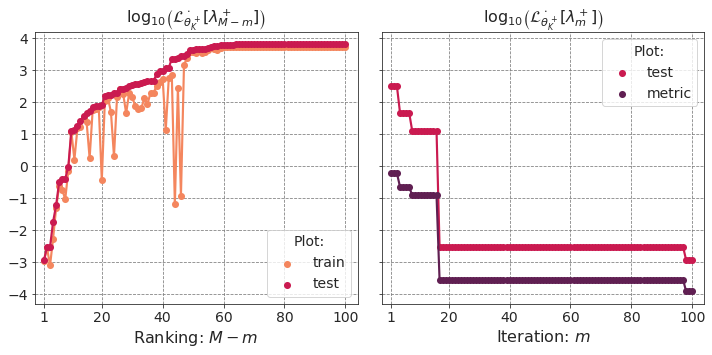

In [5]:
sns.set_style("ticks",{'axes.grid' : True})

melt = df.melt(id_vars =['local_index'], value_vars =  ['log10train', 'log10test'])
fig, (ax1, ax2) = plt.subplots(1,2 , sharey=True, figsize= (12, 5))

g = sns.pointplot(data = melt, x = 'local_index', 
                 palette = sns.color_palette('rocket_r', n_colors=3), 
                 y = 'value',
                 scale = .8, s = 80, lw = 2,
                 hue='variable',
                 ax = ax1)
                 
#ax.set_xlabel(r'$\lambda_{M-m}^+$ Ranking')
ax1.set_title(r'$\log_{10}\left(\mathcal{L}^\cdot_{\theta_K^+}[\lambda_{M-m}^+]\right)$', fontsize=16)

ax1.set_ylabel(r'')
ax1.set_xlabel(r'Ranking: $M-m$', fontsize=16)

xticks = np.array([0, 19, 39, 59, 79, 99])
ax1.grid()
ax1.set_xlim(-3,103)
labels = ax1.get_xticklabels() # get x labels

ax1.set_xticks(xticks)
ax1.set_xticklabels((xticks + 1).astype(str), fontsize= 14)
#ax1.set_yticklabels(labelsy, fontsize= 14)
ax1.xaxis.grid(color='gray', linestyle='dashed')
ax1.yaxis.grid(color='gray', linestyle='dashed')
#ax.tick_params(axis='both', which='major')
#title = ax.get_title()


handles, labels = ax1.get_legend_handles_labels() 

labels = ['train', 'test', 'metric']
legend = ax1.legend(loc = 'lower right', handles = handles, labels = labels, title = 'Plot:', fontsize=14)  
legend.get_title().set_fontsize('14')

# AX2
melt = df.melt(id_vars =['global_index'], value_vars =  ['log10conv','log10conv_metric'])
g = sns.pointplot(data = melt, x = 'global_index', 
                 palette = sns.color_palette('rocket_r', n_colors=3)[1:3], 
                 y = 'value',
                 scale = .8, s = 80, lw = 2,
                 hue='variable',
                 ax = ax2)
ax2.set_xlabel(r'Iteration: $m$', fontsize=16)
ax2.set_title(r'$\log_{10}\left(\mathcal{L}^\cdot_{\theta_K^+}[\lambda_{m}^+]\right)$', fontsize=16)
ax2.set_ylabel(r'')

xticks = np.array([0, 19, 39, 59, 79, 99])

ax2.grid()
ax2.set_xlim(-3,103)

labels = ax2.get_xticklabels() # get x labels
labelsy = ax1.get_yticklabels() # get x labels

ax1.tick_params(axis='both', which='major', labelsize=14)


ax2.set_xticks(xticks)
ax2.set_xticklabels((xticks + 1).astype(str), fontsize=14)

ax2.xaxis.grid(color='gray', linestyle='dashed')
ax2.yaxis.grid(color='gray', linestyle='dashed')
#title = ax.get_title()


handles, labels = ax2.get_legend_handles_labels() 

labels = ['test', 'metric']
legend = ax2.legend(loc = 'upper right', handles = handles, labels = labels, title = 'Plot:',fontsize =14)  
legend.get_title().set_fontsize('14')


plt.subplots_adjust(wspace=0.075, hspace=0.075)

plt.savefig('plots/s01.pdf')

In [6]:
0.142 * 60 

8.52

<Figure size 432x288 with 0 Axes>

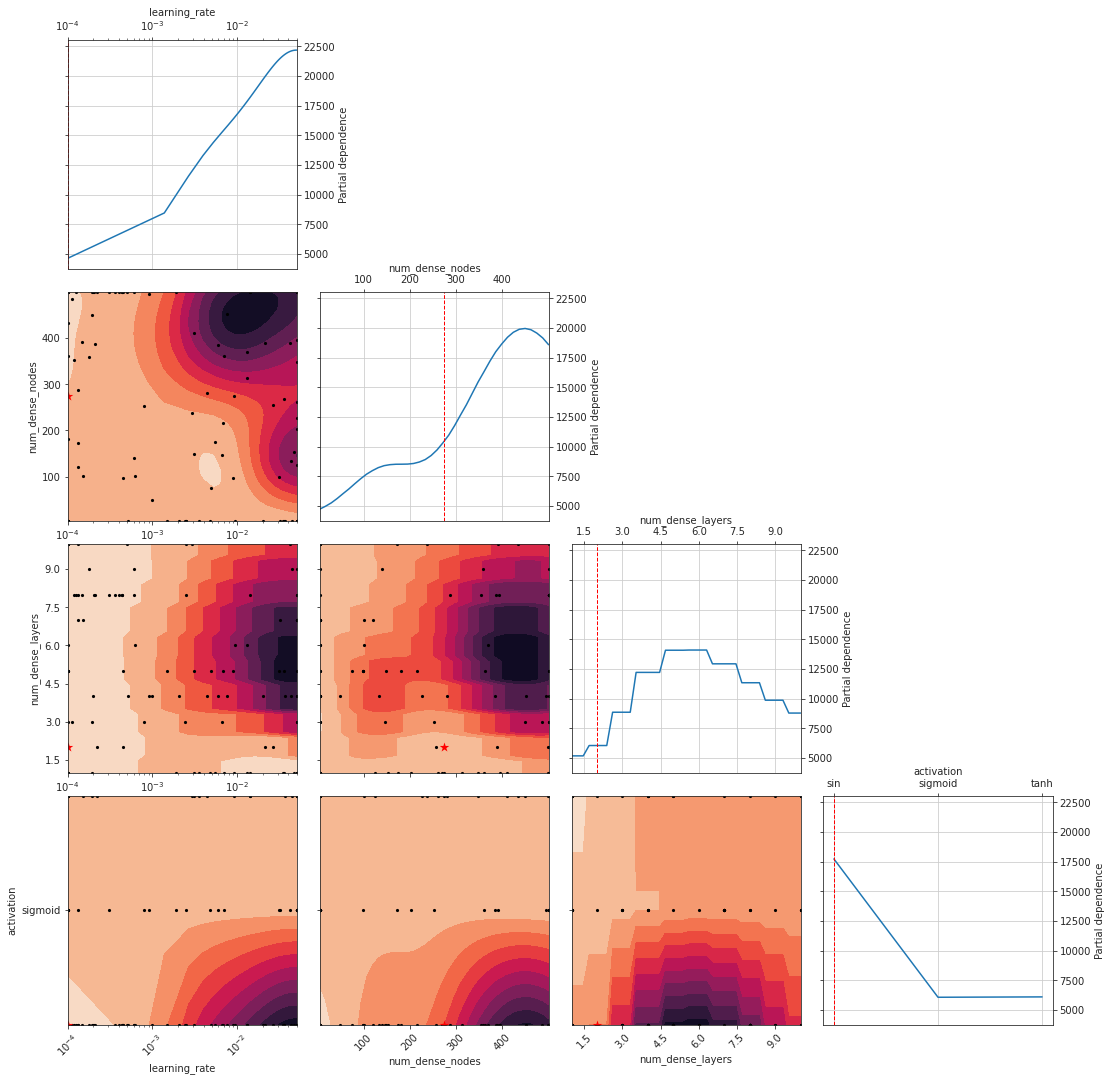

In [7]:
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
#from matplotlib import pyplot as plt

fig = plt.figure()
test = plot_objective(search_result, plot_dims = ['learning_rate', 'num_dense_nodes', 'num_dense_layers', 'activation'], show_points=True, size =3.8, cmap = 'rocket_r')

plt.savefig('plots/s03.pdf', bbox_inches='tight')

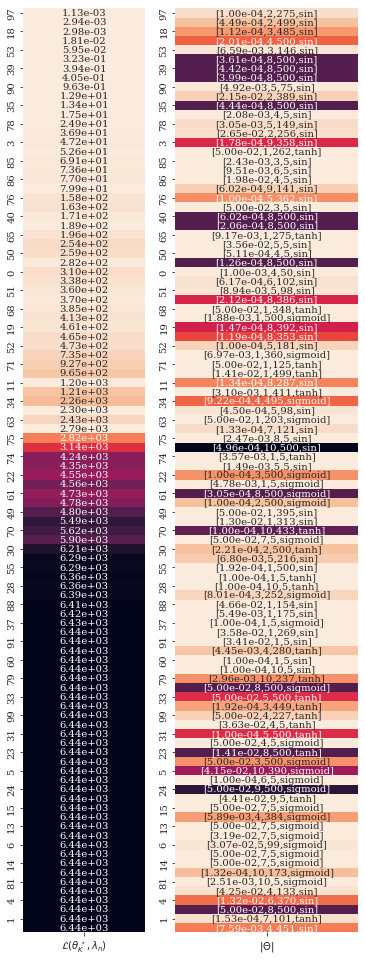

In [8]:
fmin, fmax = df.f.min(), df.f.max()
cmin, cmax = df.cost.min(), df.cost.max()

plt.rc('font', family='serif')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6,17), gridspec_kw={'width_ratios': [1,1.5]})
g =  sns.heatmap(df[['train']], annot =df[['f_format']], fmt = '' , cmap = 'rocket_r', ax = ax1, cbar_kws = dict(use_gridspec=False,location="left"), cbar = None, xticklabels = [r'$\mathcal{L}(\theta_K^\star, \lambda_n)$'])
g =  sns.heatmap(df[['cost']], annot =df[['information']], fmt = '' , cmap = 'rocket_r', ax = ax2, cbar = None, xticklabels = [r'$|\Theta|$'])
ax1.xaxis.tick_bottom() # x axis on top

#ax1.xaxis.set_label_position('top')


ax2.xaxis.tick_bottom() # x axis on top

plt.savefig('plots/s04.pdf')



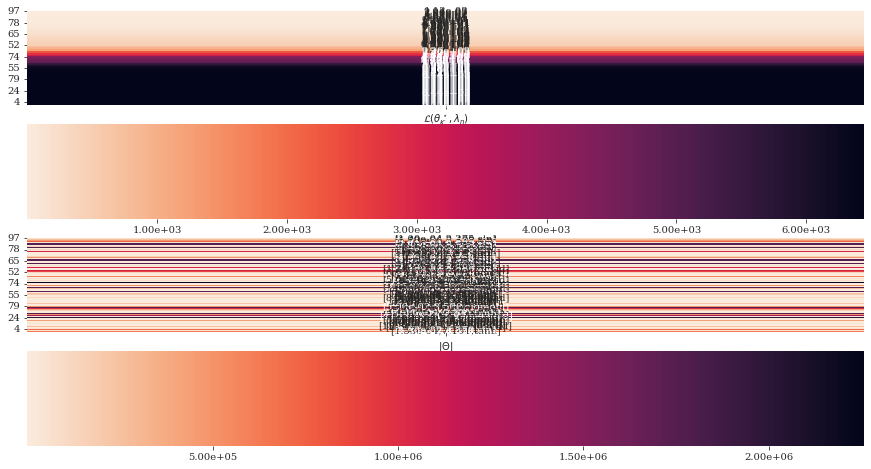

In [9]:

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (15,8))

g =  sns.heatmap(df[['f']], annot =df[['f_format']], fmt = '' , cmap = 'rocket_r', ax = ax1, cbar_kws = dict(use_gridspec=False, orientation = "horizontal", format = '%.2e'), cbar = True, xticklabels = [r'$\mathcal{L}(\theta_K^\star, \lambda_n)$'], cbar_ax =ax2)
g =  sns.heatmap(df[['cost']], annot =df[['information']], fmt = '' , cmap = 'rocket_r', ax = ax3, cbar = True, xticklabels = [r'$|\Theta|$'], cbar_kws = dict(use_gridspec=False, orientation = "horizontal", format = '%.2e'), cbar_ax=ax4)


plt.savefig('plots/s05.pdf')

In [10]:
print('fmin-fmax', fmin, fmax)
print('cmin-cmax', cmin, cmax)

fmin-fmax 0.0011304444633424282 6444.59326171875
cmin-cmax 21.0 2256501.0


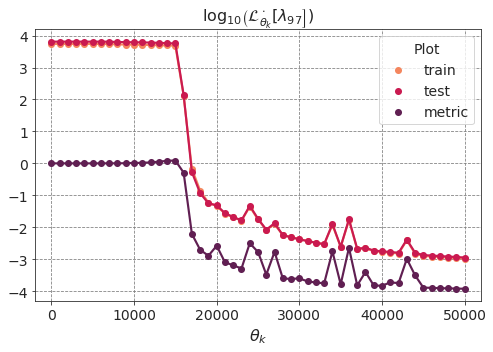

In [11]:

index = 97
dfbest = pd.DataFrame(np.column_stack([np.arange(trainF[index].shape[0]) * 1000, np.log10(trainF[index]), np.log10(testF[index]),np.log10(metricF[index])]), columns = ['epoch', 'train', 'test', 'metric'])    

melt = dfbest.melt(id_vars = ['epoch'], value_vars = ['train', 'test', 'metric'])


sns.set_style("ticks",{'axes.grid' : True})

fig, ax = plt.subplots(figsize= (8,5))

g = sns.pointplot(data = melt, x = 'epoch', 
                 palette = sns.color_palette('rocket_r', n_colors=3), 
                 y = 'value',
                 scale = .8, s = 80, lw = 2,
                 hue='variable',
                 ax = ax)
                 
                 
ax.set_xlabel(r'$\theta_{k}$', fontsize=  16)
ax.set_title(r'$\log_{10}\left(\mathcal{L}^\cdot_{\theta_k}[\lambda_{97}\right])$', fontsize=16)



#xticks = np.array([0, 10000, 20000, 30000, 40000, 50000])#+1

xticks = np.array([0, 10, 20, 30, 40, 50])
xlabels = ['0', '10000', '20000', '30000', '40000', '50000']
ax.set_xlim(-2,52)

ax.grid()

#labels = ax.get_xticklabels() # get x labels
ax.set_ylabel(r'', fontsize=  16)

ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')
#ax.tick_params(axis='both', which='major')
title = ax.get_title()


handles, labels = ax.get_legend_handles_labels() 

labels = ['train', 'test', 'metric']
legend = ax.legend(loc = 'upper right', handles = handles, labels = labels, title = 'Plot', fontsize =14)
legend.get_title().set_fontsize('14')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig('plots/s12.pdf', bbox_inches='tight')

In [12]:
dfbest2 = pd.DataFrame(np.column_stack([np.arange(trainF[index].shape[0]) * 1000, trainF[index], testF[index], metricF[index]]), columns = ['epoch', 'train', 'test', 'metric'])    



In [13]:
df.train, df.test

(97       0.001042
 16       0.002775
 18       0.000775
 45       0.005371
 53       0.049451
          ...     
 87    5470.642578
 4     5470.642578
 47    5470.642578
 1     5469.662109
 48    5470.642578
 Name: train, Length: 100, dtype: float64,
 97       0.001130
 16       0.002936
 18       0.002978
 45       0.018058
 53       0.059517
          ...     
 87    6444.593262
 4     6444.593262
 47    6444.593262
 1     6444.593262
 48    6444.593262
 Name: test, Length: 100, dtype: float64)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, '$|\\Theta|$ (log scale)')

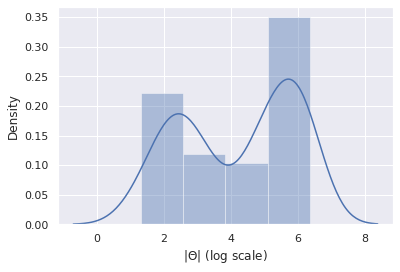

In [14]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
x = np.log10(df.cost)
ax = sns.distplot(x)
ax.set_xlabel(r'$|\Theta|$ (log scale)')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, '$t_{\\mathrm{texec}}$')

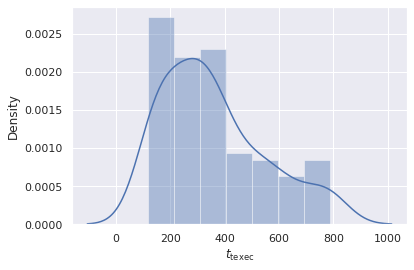

In [15]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
x = df.texec
ax = sns.distplot(x)
ax.set_xlabel(r'$t_{\mathrm{texec}}$')